<h1>Mortalidad y letalidad del COVID-19 en España<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introducción" data-toc-modified-id="Introducción-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introducción</a></span></li><li><span><a href="#Procesado-de-datos" data-toc-modified-id="Procesado-de-datos-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Procesado de datos</a></span></li><li><span><a href="#Gráficos-de-evolución" data-toc-modified-id="Gráficos-de-evolución-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Gráficos de evolución</a></span><ul class="toc-item"><li><span><a href="#Evolución-de-la-tasa-de-mortalidad" data-toc-modified-id="Evolución-de-la-tasa-de-mortalidad-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Evolución de la tasa de mortalidad</a></span></li><li><span><a href="#Evolución-de-la-tasa-de-letalidad" data-toc-modified-id="Evolución-de-la-tasa-de-letalidad-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Evolución de la tasa de letalidad</a></span></li><li><span><a href="#Mortalidad-vs.-Letalidad" data-toc-modified-id="Mortalidad-vs.-Letalidad-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Mortalidad vs. Letalidad</a></span></li><li><span><a href="#Evolución-tasa-de-recuperación" data-toc-modified-id="Evolución-tasa-de-recuperación-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Evolución tasa de recuperación</a></span></li></ul></li><li><span><a href="#Mapas" data-toc-modified-id="Mapas-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Mapas</a></span><ul class="toc-item"><li><span><a href="#Mapa-de-mortalidad" data-toc-modified-id="Mapa-de-mortalidad-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Mapa de mortalidad</a></span></li><li><span><a href="#Mapa-de-letalidad" data-toc-modified-id="Mapa-de-letalidad-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Mapa de letalidad</a></span></li></ul></li></ul></div>

# Introducción


* Este notebook contiene un análisis regional del impacto del COVID-19 en España. Se analiza la evolución de la tasa de [mortalidad](https://es.wikipedia.org/wiki/Tasa_bruta_de_mortalidad) y de [letalidad](https://es.wikipedia.org/wiki/Tasa_de_letalidad) para las distintas Comunidades Autónomas (CCAA), comparando dichas evoluciones con la que presenta España en su conjunto. Por otro lado, se presentan mapas de letalidad y mortalidad para comparar el impacto del virus en las distintas CCAA. Si se desea consultar el análisis para obtener la "famosa" curva del COVID-19 en España y Madrid, se puede consultar el notebook que predece a este: [COVID-19 in Spain and Madrid](https://github.com/DiegoDZ/covid19/blob/master/covid19.ipynb).



* Las conclusiones han sido extraídas prácticamente a vuelapluma. La intención de este análisis no es hallar respuestas a preguntas que a día de hoy no tenemos, sino interpretar los gráficos para plantear nuevas cuestiones.


* Los datos de casos, hospitalizados, hospitalizados en la UCI, fallecidos y recuperados han sido extraídos de la web del [Instituto de Salud Carlos III](https://covid19.isciii.es). Por otro lado, el censo de España ha sido obtenido a partir de los últimos datos disponibles del [Insituto Nacional de Estadística](https://www.ine.es/jaxiT3/Datos.htm?t=2915)


* Los mapas han sido realizado empleando la librería [geopandas](https://geopandas.org). Los ficheros geojson de España fueron descargados de [DIVA-GIS](https://www.diva-gis.org/gdata). Los correspondientes a los océanos se encuentran en [Natural Earth Data](https://www.naturalearthdata.com). 



---------

Notebook creado por [@DiegoDZ](https://github.com/DiegoDZ). La sección *Procesado de datos* fue iniciada por [@manu-jimenez](https://github.com/manu-jimenez) en [este](https://github.com/manu-jimenez/covid19-manu/blob/master/covid19-manu.ipynb) análisis.

--------

In [7]:
# Librerías y estética de las gráficas

import io
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from geopandas import GeoDataFrame
import requests
import time
import matplotlib
plt.style.use('fivethirtyeight')

# Procesado de datos

In [8]:
# Diccionario códigos y nombres CCAA

names_ccaa = {'AN':'Andalucía','AR':'Aragón','AS':'Asturias','CB':'Cantabria','CE':'Ceuta','CL':'Castilla y León',
              'CM':'Castilla-La Mancha', 'CN':'Canarias','CT':'Cataluña', 'EX':'Extremadura','GA':'Galicia',
              'IB':'Baleares','MC':'Murcia','MD':'Madrid','ME':'Melilla','NC':'Navarra','PV':'País Vasco',
              'RI':'La Rioja','VC':'Comunidad Valenciana','Principado de Asturias':'Asturias',
              'Islas Canarias':'Canarias', 'Islas Baleares':'Baleares', 'Región de Murcia':'Murcia', 
              'Comunidad de Madrid':'Madrid', 'Comunidad Foral de Navarra':'Navarra'
               }

In [9]:
# Extracción datos COVID-19
req = requests.get("https://covid19.isciii.es/resources/serie_historica_acumulados.csv")
csv = req.content.decode('ISO-8859-1')

filename = 'serie_historica_acumulados.csv'
with open(filename, 'w') as f:
    f.write(csv)
    
# Lectura csv con censo España 2019 (Fuente: INE)
population = pd.read_csv('./data/censo_espana_2019.csv',sep=';')
population.replace({'Region': names_ccaa}, inplace= True)

In [10]:
# Crear dataframe. Si fallara la descarga del csv desde web usar: df = pd.read_csv('serie_historica_acumulados.csv')
df0 = pd.read_csv(io.StringIO(csv), sep=',', skipfooter=1, parse_dates=[1], dayfirst=True, engine='python')

df0.head()

,CCAA Codigo ISO,Fecha,Casos,Hospitalizados,UCI,Fallecidos,Recuperados
0,AN,2020-02-20,NaN,NaN,NaN,NaN,NaN
1,AR,2020-02-20,NaN,NaN,NaN,NaN,NaN
2,AS,2020-02-20,NaN,NaN,NaN,NaN,NaN
3,IB,2020-02-20,1.0,NaN,NaN,NaN,NaN
4,CN,2020-02-20,1.0,NaN,NaN,NaN,NaN


In [11]:
# Renombrar columna y cambiar código de CCAA por nombres
df0.rename(columns={'CCAA Codigo ISO': 'Region', 'Casos ': 'Casos'}, inplace = True)
df0.replace({'Region': names_ccaa}, inplace=True)

# Quitar columnas que no se van a usar
df0.drop(['Hospitalizados', 'UCI'], axis=1, inplace=True)

# Sustituir NaN por 0. 
df0[['Casos', 'Fallecidos', 'Recuperados']] = df0[['Casos', 'Fallecidos', 'Recuperados']].fillna(0)

# Cálculo variables en España
df0 = df0.sort_values(by=['Region','Fecha']).reset_index(drop=True)
total_spain = df0.groupby('Fecha').sum().reset_index()
total_spain['Region'] = ['España'] * len(total_spain)

# Concatenar dataframes
df0 = pd.concat([total_spain, df0])

# Añadir numeración de días desde origen pandemia
df0['Dia'] = df0.groupby('Region')['Fecha'].transform(lambda x: x - x.iloc[0]).dt.days 

df0.head()

,Fecha,Casos,Fallecidos,Recuperados,Region,Dia
0,2020-02-20,2.0,0.0,0.0,España,0.0
1,2020-02-21,2.0,0.0,0.0,España,1.0
2,2020-02-22,2.0,0.0,0.0,España,2.0
3,2020-02-23,2.0,0.0,0.0,España,3.0
4,2020-02-24,3.0,0.0,0.0,España,4.0


In [12]:
# Calcular nuevas variables empleando la población por región. 

df0 = df0.merge(population, 'left', on='Region')

df0['Letalidad'] = df0['Fallecidos'] / df0['Casos'] * 100
df0['Mortalidad'] = df0['Fallecidos'] / df0['Population'] * 100
df0['Tasa_recuperados'] = df0['Recuperados'] / df0['Casos'] * 100

In [13]:
# Coger únicamente los datos a partir de los primeros 100 contagiados
df = df0[df0['Casos']>100]

In [14]:
df.columns

Index(['Fecha', 'Casos', 'Fallecidos', 'Recuperados', 'Region', 'Dia',
       'Population', 'Letalidad', 'Mortalidad', 'Tasa_recuperados'],
      dtype='object')

# Gráficos de evolución 

In [15]:
# Listas y constantes
ccaa_list = list(df['Region'].drop_duplicates())
number_ccaa = len(ccaa_list)
ncols=3
nrows=round(len(ccaa_list)/ncols)

# Subrutina para crear gráficos de líneas por región
def generateRegionsPlot(variable, supTitle, yLabel, varColor):
    fig = plt.figure(figsize=(20,20))
    fig.subplots_adjust(hspace=0.5, wspace=0.4)
    
    for element,i in zip(ccaa_list, range(1, len(ccaa_list)+1)):
        df_by_region = df[df['Region']==element][['Dia',variable]]
        ax = fig.add_subplot(nrows, ncols, i)
        
        if element!='España':
            ax.plot(range(len(df_by_region[variable])), df_by_region[variable], color = varColor, label = 'Región')
        
        ax.plot(range(len(df[df['Region']=='España'][variable])), df[df['Region']=='España'][variable], color='gray', label ='España')
        ax.set_title(element)
        ax.set(xlabel='Día', ylabel=yLabel)
        
    fig.suptitle(supTitle,y=1.1, fontsize=35)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels,bbox_to_anchor=(0.35, 1.04, 0.3,0), mode='expand',ncol=2, fontsize=20)
    fig.text(0.2, 1.06, r'El día 0 corresponde al primer día en el que se registraron 100 o más contagiados en la región'
         ,alpha=0.6, fontsize=18)
    fig.tight_layout()
    return plt.show()

## Evolución de la tasa de mortalidad

En el gráfico siguiente se presenta la evolución de la tasa de mortalidad para España y las distintas CCAA. Los datos representados han sido desplazados para que las curvas comiencen en el día 0 (día en el que se registran los primeros 100 o más contagiados por COVID-19 en cada una de las regiones).

Algunas conclusiones que se pueden extraer de las gráficas: 


1. Es llamativo obsevar cómo en las CCAA de Castilla y León, Castilla-La Mancha, Madrid, Extremadura, Navarra y Cataluña, la evolución de la mortalidad se dispara en comparación con la de España. Es en estas comunidades en donde se registran las mayores tasas de mortalidad.


2. Murcia, Galicia, Asturias, Andalucía, Baleares y Canarias consiguieron mantener la mortalidad más o menos estable a partir de los primeros 100 contagios registrados. 


3. Andalucía y Canarias son las CCAA en las que las que la mortalidad es inferior a la de España en su conjunto. Ceuta y Melilla no han sido incluidas porque no tienen más de 100 casos confirmados en el día en que se realizó este análisis (5 abril 2020).

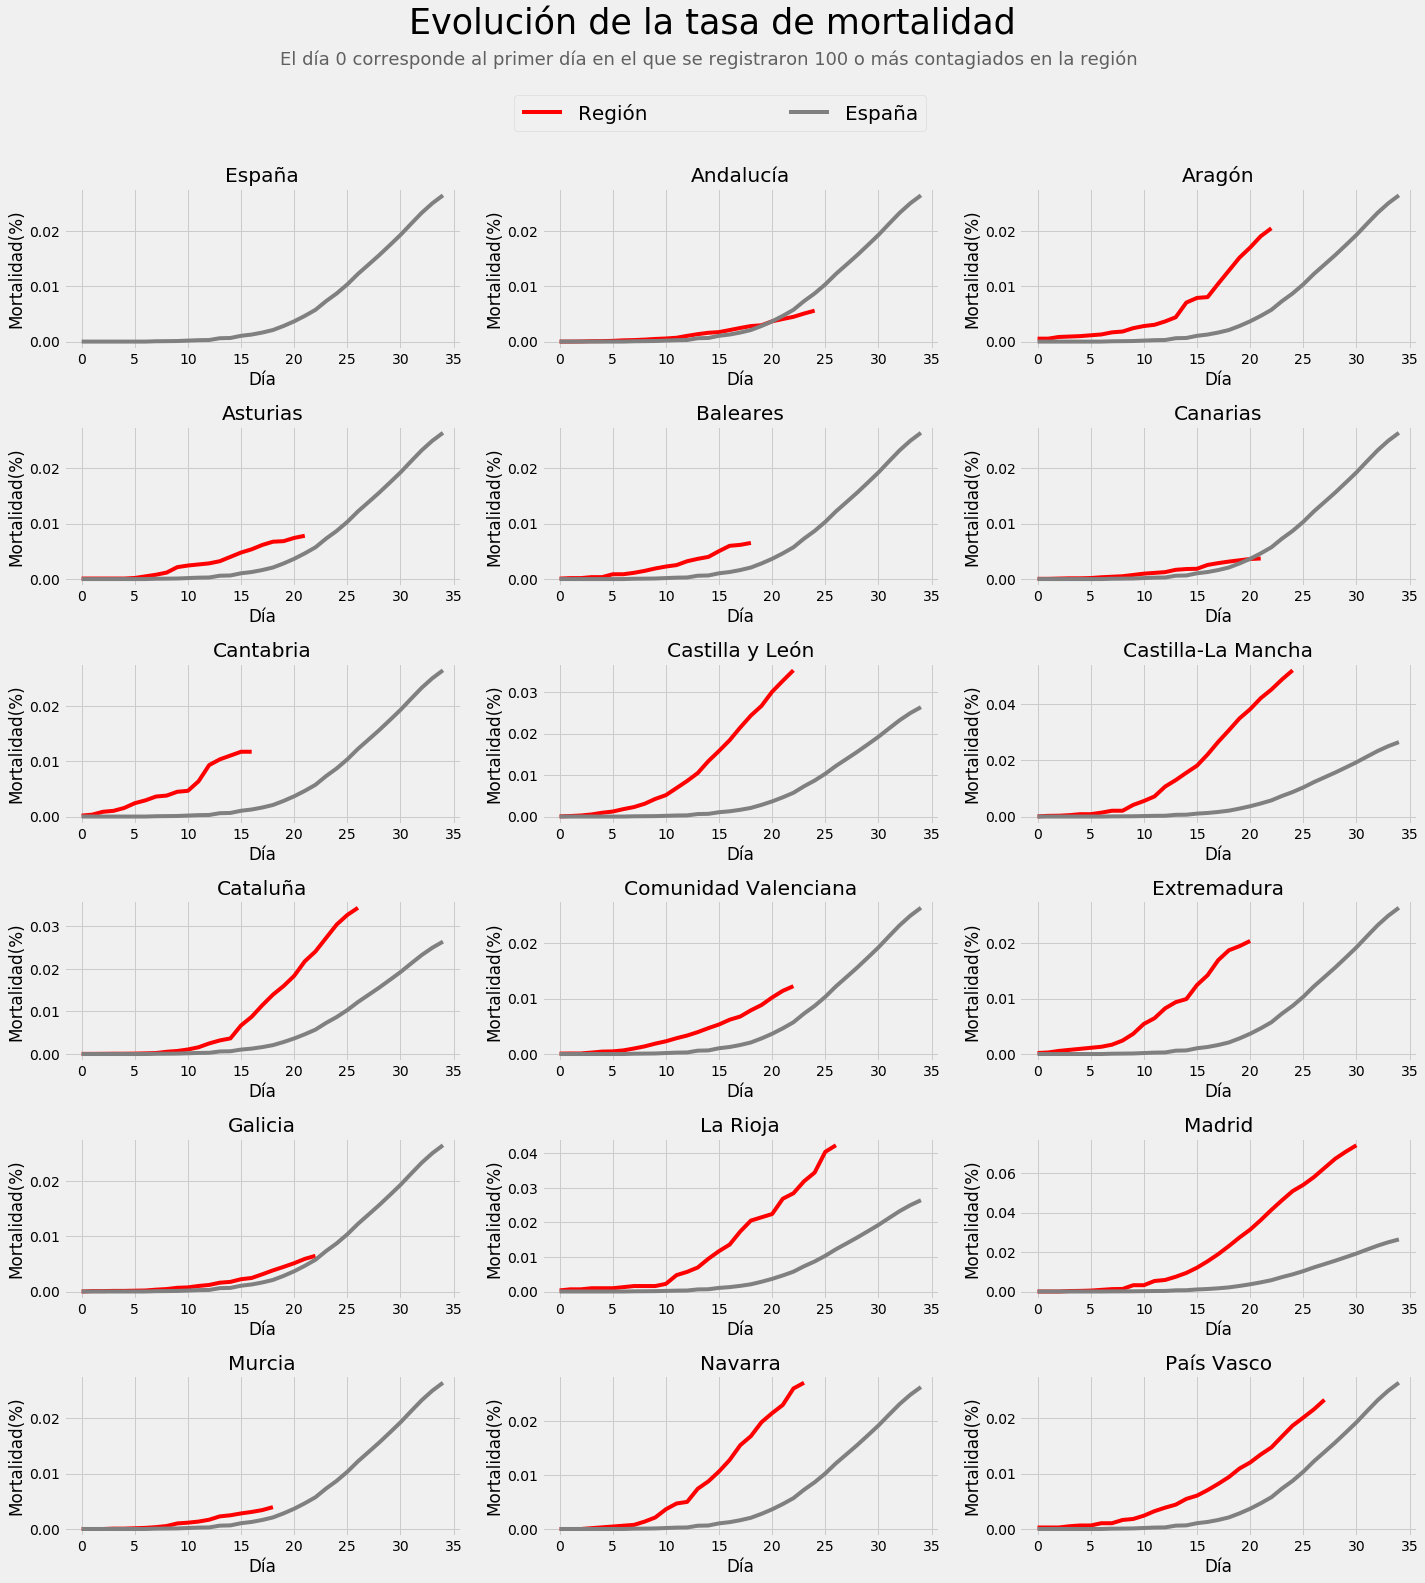

In [16]:
generateRegionsPlot('Mortalidad', 'Evolución de la tasa de mortalidad', 'Mortalidad(%)', 'red')

## Evolución de la tasa de letalidad

Es en los gráficos de letalidad donde realmente se puede estudiar cómo afecta el virus a las personas contagiadas.

En el siguiente gráfico se representa la evolución de la tasa de letalidad en España y todas las CCAA. Al igual que en el gráfico anterior, el día 0 corresponde al día en el que se registraron los primeros 100 o más contagiados por COVID-19 en cada una de las regiones. 

A continuación se enumeran algunas conclusiones que se pueden extraer al analizar las gráficas: 

1. La tasa de letalidad tiene un comportamiento creciente. Esto puede ser debido a que el crecimiento de los contagiados no fue acorde al crecimiento del número de tests realizados. Los test solo se fueron realizando a los hospitalizados, por lo que [solo se empezaron a registar casos de coronavirus graves](https://elpais.com/sociedad/2020-03-17/sanidad-reconoce-su-incapacidad-para-hacer-las-pruebas-necesarias.html) (asintomáticos o casos leves se dejaron de detectar). 


2. Castilla y León, Castilla-La Mancha, Comunidad Valenciana, Extremadura, Madrid, Aragón y Cataluña son la comunidades en las que claramente la tasa de letalidad es superior a la del conjunta de España. La explicación puede depender de multitud de variables tales como saturación de hospitales, edad de los infectados, antecedentes médicos, etcétera. 


__Nota__: Estas conclusiones están condicionadas por el número de tests realizados por las diferentes CCAA.  

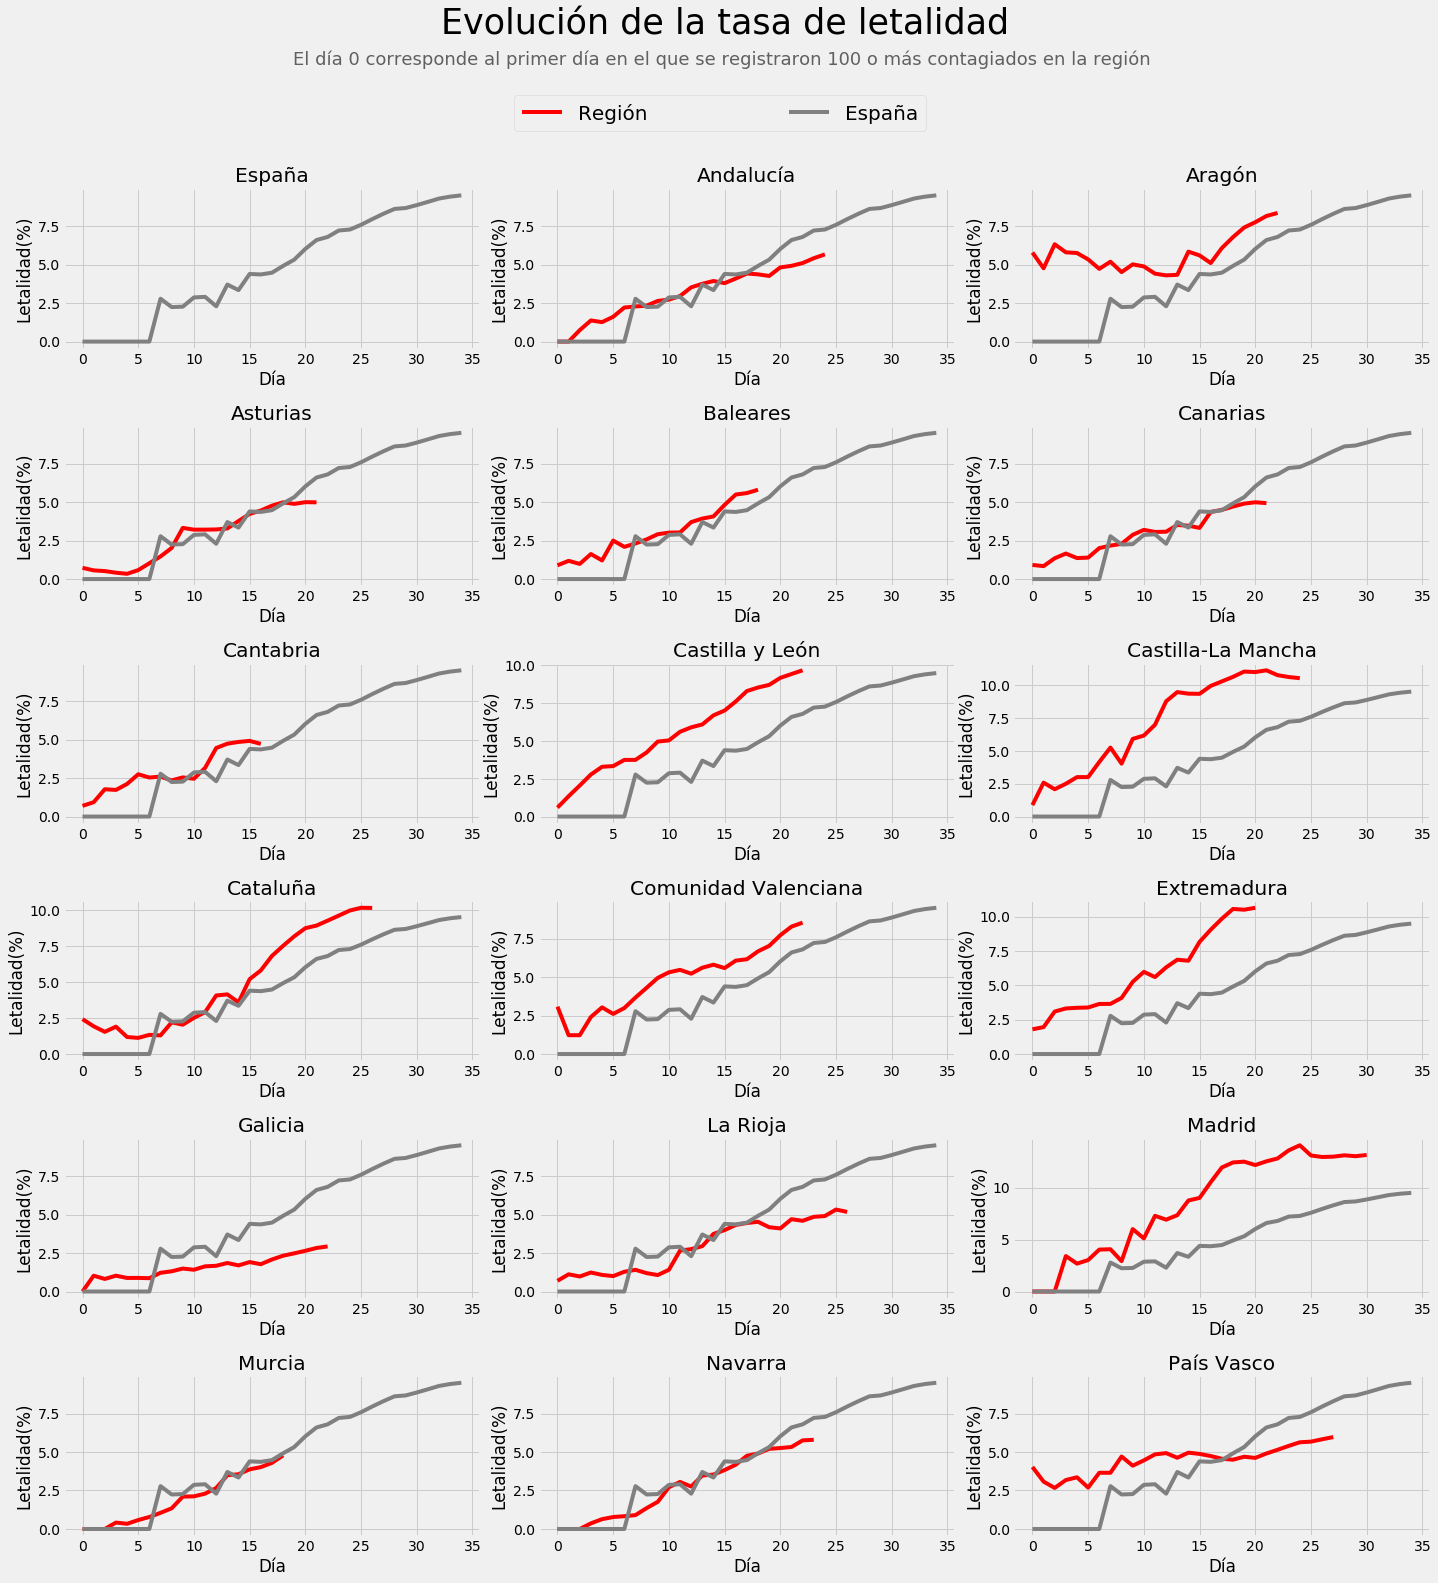

In [17]:
generateRegionsPlot('Letalidad', 'Evolución de la tasa de letalidad', 'Letalidad(%)', 'red')

## Mortalidad vs. Letalidad

In [18]:
# Subrutina para pintar un gráfico de dispersión con burbujas
def scatterPlot(varX,varY, xLabel, yLabel, titlePlot):
    fig = plt.figure(figsize=(20,13))
    for element,i in zip(ccaa_list, range(1, len(ccaa_list)+1)):
        if element!='España':
            df_by_region = df[df['Region']==element][[varX,varY, 'Casos']]
            x = df_by_region[varX].iloc[-1]
            y = df_by_region[varY].iloc[-1]
            s = df_by_region['Casos'].iloc[-1]
            plt.scatter(x,y, s=s*0.2, cmap='Blues', alpha = 0.6,linewidth=2)
            plt.text(x-0.15, y, element, fontsize=12)
     
    plt.title(titlePlot, y=1.1, fontsize=35)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    fig.text(0.33, 0.93, r'El área del círculo es proporcional a los casos confirmados'
         ,alpha=0.6, fontsize=18)
    plt.show()

El gráfico de dispersión *Mortalidad vs. Letalidad* nos permite tener una visión global de las tasas de mortalidad y letalidad para las diferentes CCAA. El área de los círculos es propocional al número de casos confirmados. Observamos: 

1. Madrid, Castilla-La Mancha, Castila y León, Cataluña y Extremadura son las CCAA en donde el virus tienen una mayor letalidad. Es en esas comunidades en las que también se registran las mayores cifras de contagiados. 


2. Aunque es una conclusión precipitada, se podría decir que a mayor número de casos confirmados la letalidad es mayor. Hay excepciones como Extremadura, cuya letalidad es demasiado alta teniendo un número de casos confirmados muy pequeño en comparación con el del resto de comunidades. Otras comunidades, como País Vasco y Andalucía, en donde el número de contagiados es similar al de las dos castillas, tienen tasas de letalidad más pequeñas. 

__Nota__: Estas conclusiones están condicionadas por el número de tests realizados por las diferentes CCAA.  

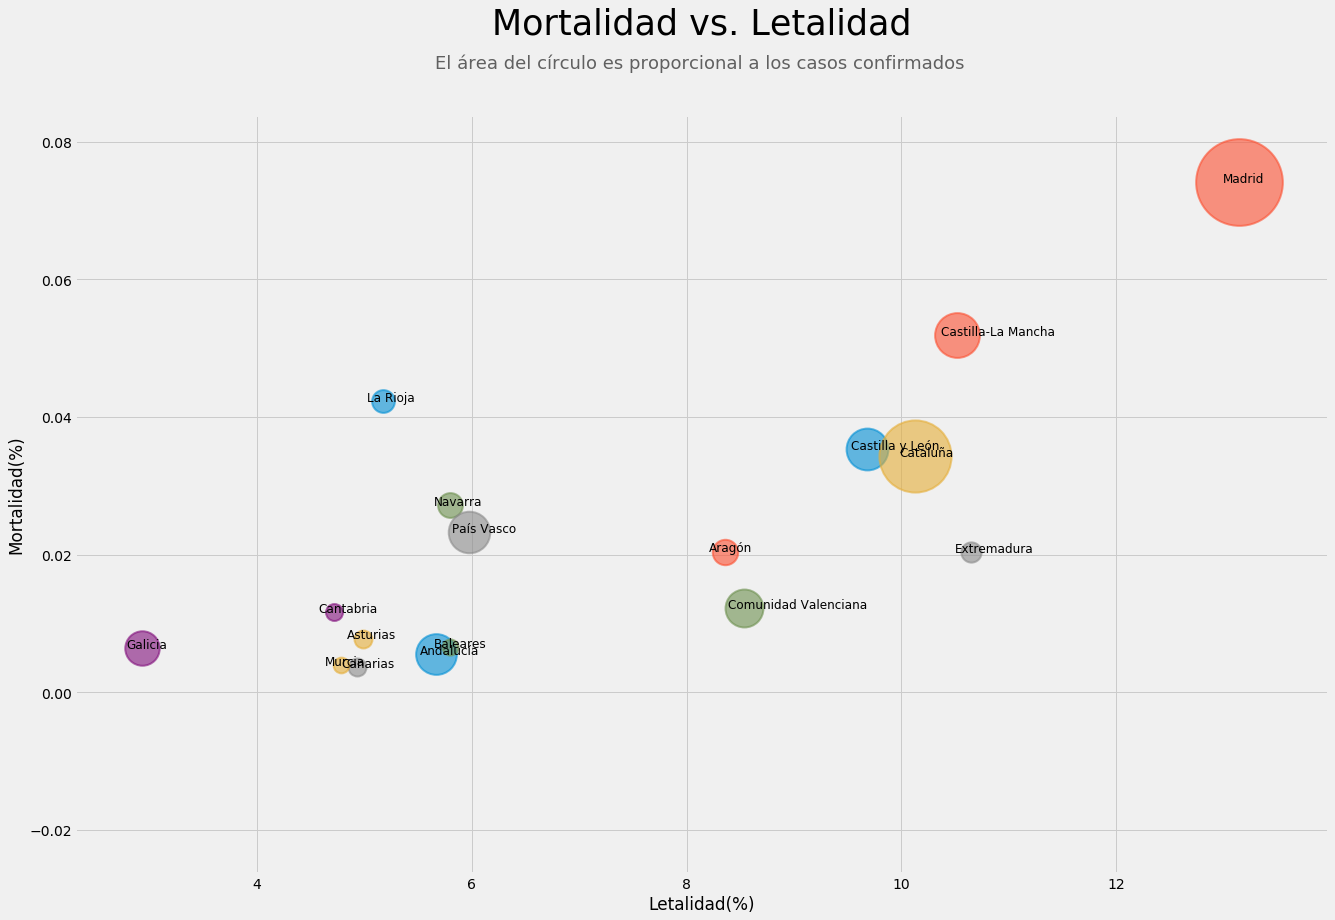

In [19]:
scatterPlot('Letalidad','Mortalidad', 'Letalidad(%)', 'Mortalidad(%)', 'Mortalidad vs. Letalidad')

## Evolución tasa de recuperación

Aunque no es objetivo de este análisis, a continuación se muestra la evolución de la tasa de recuperación para las diferentes CCAA de España. La tasa de recuperación es el número de recuperados despues de haberse contagiado por coronavirus. Podríamos decir que es lo opuesto a la letalidad (da cuenta del personas contagiadas que finalmente mueren). 

Tal y como se ha comentado en los gráficos de la evolución de las tasas de letalidad y mortalidad, el día 0 corresponde al día en el que se contabilizaron los primeros 100 contagios en la región. 

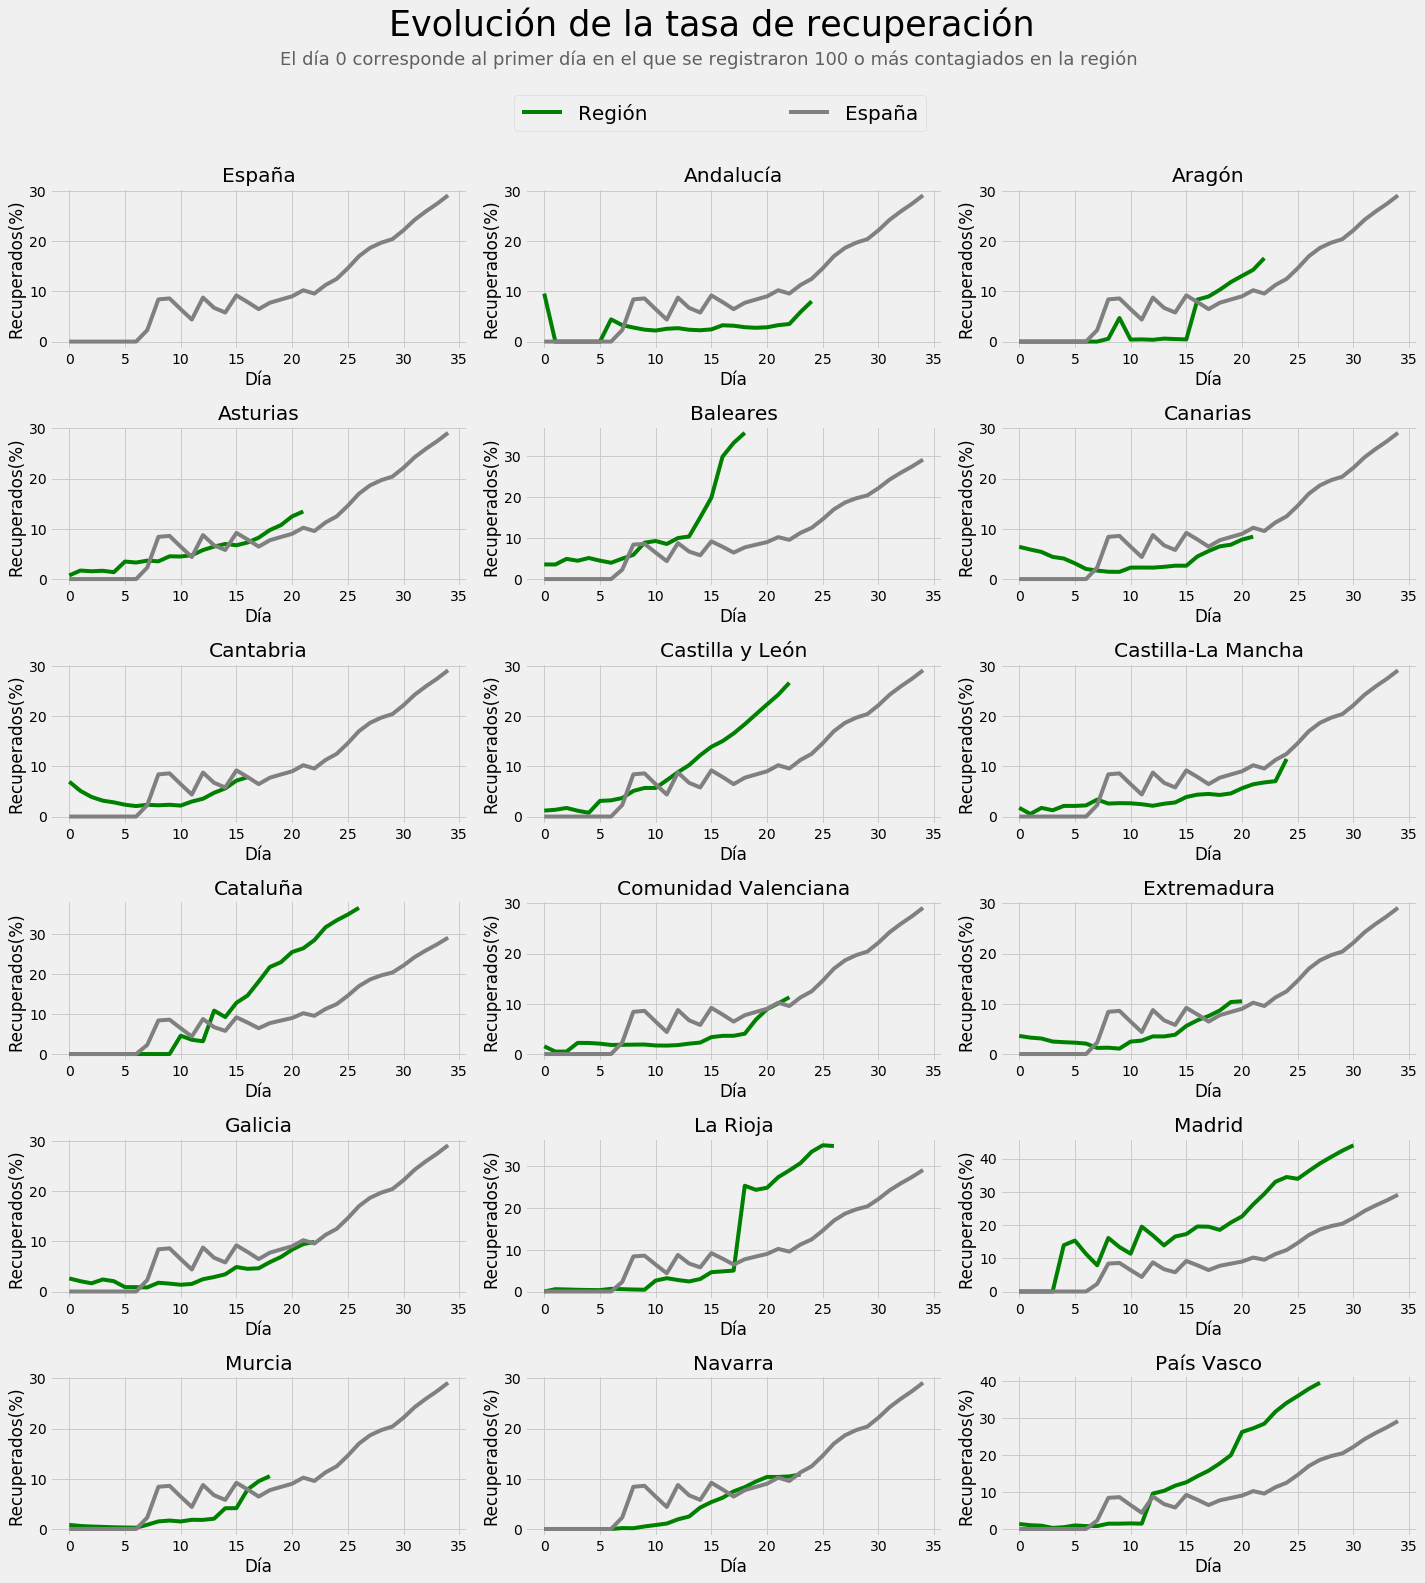

In [21]:
generateRegionsPlot('Tasa_recuperados', 'Evolución de la tasa de recuperación', 'Recuperados(%)', 'green')

# Mapas

In [22]:
# Crear dataframe con las coordenadas de cada región
shp_file = './data/ESP_adm/ESP_adm1.shp'
map_data = gpd.read_file(shp_file)
map_data.rename(columns={'NAME_1':'Region'}, inplace=True)
map_data.replace({'Region': names_ccaa}, inplace= True)
ccaa_geo = map_data[['Region','geometry']]

In [23]:
# Obtener últimos registros
mortalidad_region = []
letalidad_region = []
ccaa_list_df0 = list(df0['Region'].drop_duplicates())
for element in ccaa_list_df0:
        df_by_region = df0[df0['Region']==element][['Mortalidad','Letalidad']].iloc[-1]
        mortalidad_region.append(df_by_region['Mortalidad'])
        letalidad_region.append(df_by_region['Letalidad'])
        
# Crear dataframe con los últimos registros
df_last_record = pd.DataFrame(list(zip(ccaa_list_df0, mortalidad_region, letalidad_region)), 
               columns =['Region','Mortalidad', 'Letalidad'])

# Añadir coordenadas al dataframe df
df_last_record = df_last_record.merge(ccaa_geo, 'left', on='Region')
df_last_record.dropna(inplace=True)

# Transformar el dataframe df_last_record a uno de tipo geodataframe
crs = {'init': 'epsg:4326'}  # asigna proyeción
gdf_last_record = GeoDataFrame(df_last_record, crs=crs, geometry=df_last_record['geometry'])

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## Mapa de mortalidad

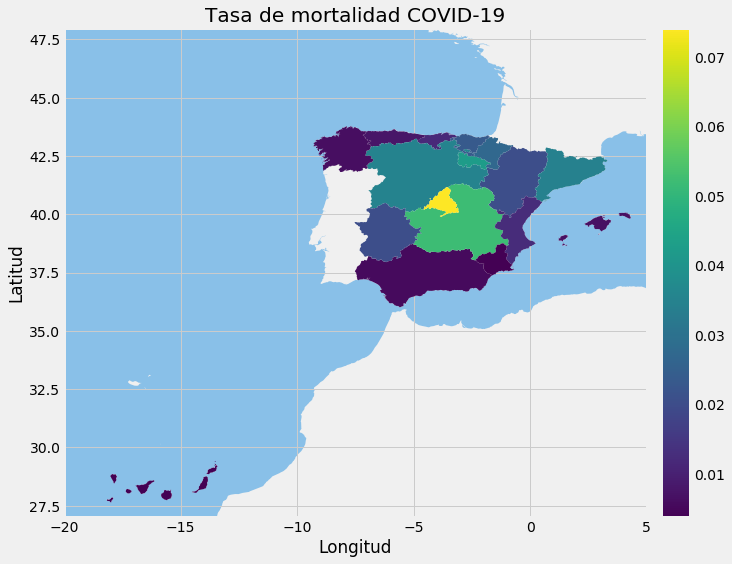

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
 
# Área geográfica del mapa
ax.axis([-20, 5, 27, 48])
 
# Añadir la leyenda separada del mapa
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
 
# Generar y cargar el mapa
gdf_last_record.plot('Mortalidad', cmap='viridis', ax=ax,legend=True, cax=cax, zorder=5)
 
# Cargar un mapa base con contornos de países
oceanos = './data/ne_10m_ocean/ne_10m_ocean.shp'
map_oceanos = gpd.read_file(oceanos)
map_oceanos.plot(ax=ax, color='#89c0e8', zorder=0)

ax.set_title('Tasa de mortalidad COVID-19')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
plt.show()

## Mapa de letalidad

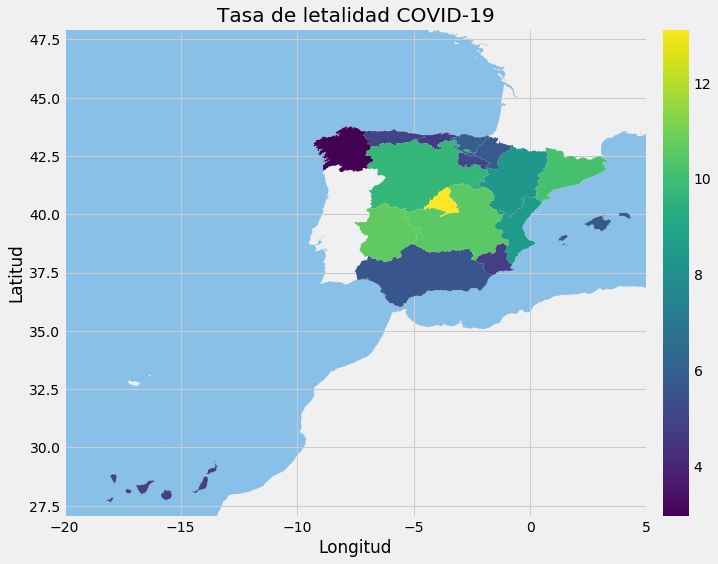

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
 
# Área geográfica del mapa
ax.axis([-20, 5, 27, 48])
 
# Añadir la leyenda separada del mapa
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
 
# Generar y cargar el mapa
gdf_last_record.plot('Letalidad', cmap='viridis', ax=ax, legend=True, cax=cax, zorder=5)
 
# Cargar un mapa base con contornos de países
map_oceanos.plot(ax=ax, color='#89c0e8', zorder=0)

ax.set_title('Tasa de letalidad COVID-19')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
plt.show()